# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Load Data 

Sample Data obtained from - https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [ ]:
df = pd.read_csv('./data/pjm_kaggle/PJM_Load_hourly.csv')
df_raw = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB


In [ ]:
df.head()

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


# Clean (Basic)

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]
print(df.index.is_monotonic_increasing)

True


In [ ]:
df.rename(columns={'PJM_Load_MW': 'demand'}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32896 entries, 1998-04-01 01:00:00 to 2002-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  32896 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [ ]:
print(df.isnull().sum())

demand    0
dtype: int64


In [ ]:
df = df.asfreq('H')

In [ ]:
print(df.head())
print(df.tail())
print(df.index.is_monotonic_increasing)  

                      demand
Datetime                    
1998-04-01 01:00:00  22259.0
1998-04-01 02:00:00  21244.0
1998-04-01 03:00:00  20651.0
1998-04-01 04:00:00  20421.0
1998-04-01 05:00:00  20713.0
                      demand
Datetime                    
2001-12-31 20:00:00  36392.0
2001-12-31 21:00:00  35082.0
2001-12-31 22:00:00  33890.0
2001-12-31 23:00:00  32590.0
2002-01-01 00:00:00  31569.0
True


In [ ]:
print(df.isnull().sum())

demand    8
dtype: int64


In [ ]:
null_rows = df[df.isnull().any(axis=1)]
print(null_rows)

                     demand
Datetime                   
1998-04-05 03:00:00     NaN
1998-10-25 02:00:00     NaN
1999-04-04 03:00:00     NaN
1999-10-31 02:00:00     NaN
2000-04-02 03:00:00     NaN
2000-10-29 02:00:00     NaN
2001-04-01 03:00:00     NaN
2001-10-28 02:00:00     NaN


In [ ]:
# df = df.dropna()
df['demand'] = df['demand'].fillna(df['demand'].mean())
print(df.isnull().sum())

demand    0
dtype: int64


# EDA

In [ ]:
df.describe()

,demand
count,32904.000000
mean,29766.427408
std,5849.058757
min,17461.000000
25%,25473.750000
50%,29656.000000
75%,33071.250000
max,54030.000000


### Visualize Raw

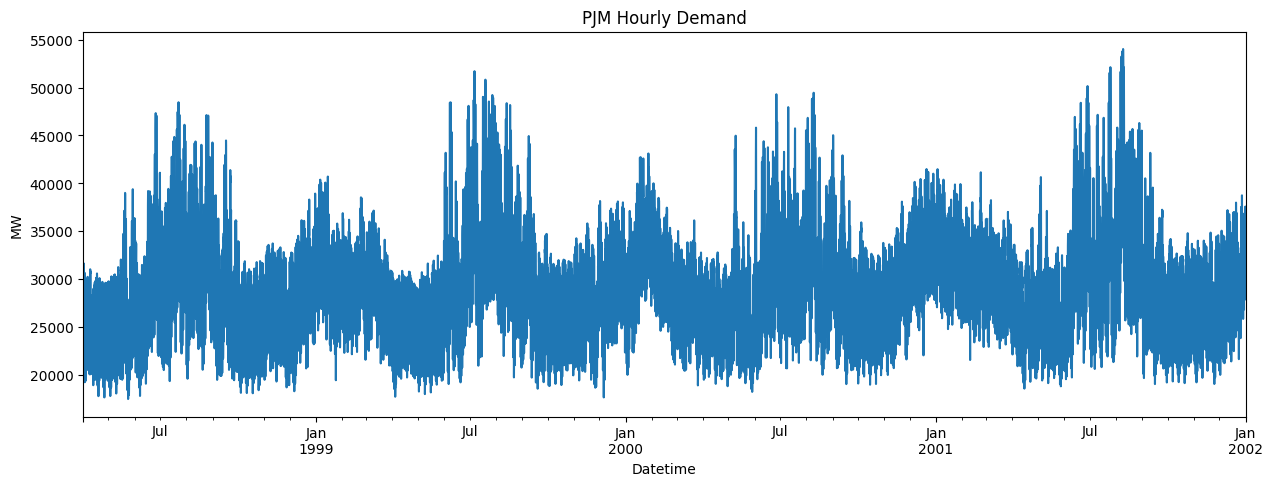

In [ ]:
plt.figure(figsize=(15,5))
df['demand'].plot(title='PJM Hourly Demand', ylabel='MW')
plt.savefig('./data/output/pjm_demand.png', dpi=300)
plt.show()

## Daily Weekly & Monthly

In [ ]:
df_daily = df['demand'].resample('D').mean()
df_weekly = df['demand'].resample('W').mean()
df_monthly = df['demand'].resample('M').mean()

### Visualize Daily

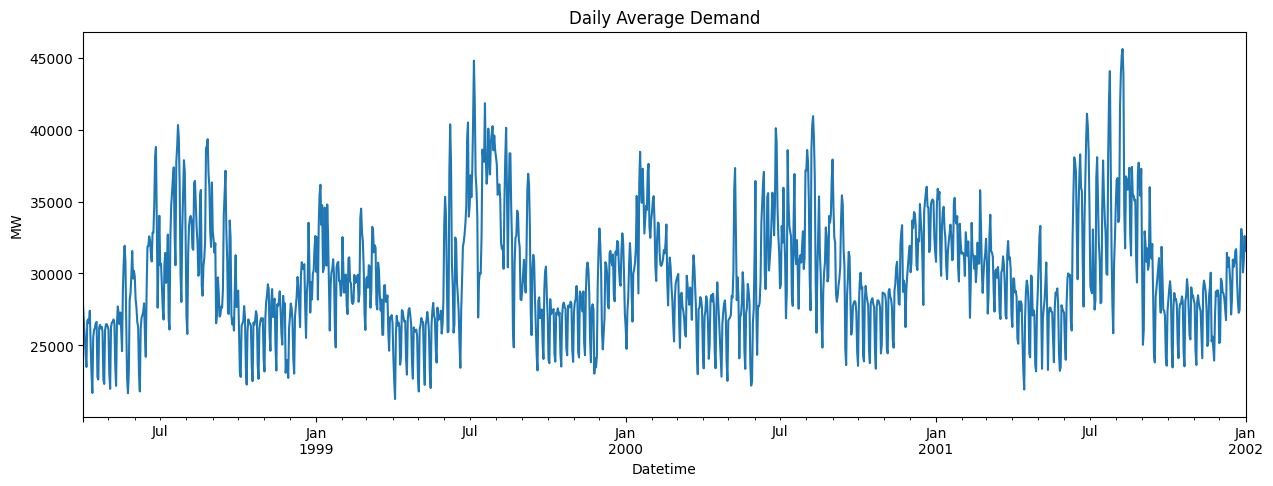

In [ ]:
plt.figure(figsize=(15,5))
df_daily.plot(title='Daily Average Demand')
plt.ylabel('MW')
plt.savefig('./data/output/pjm_demand_daily.png', dpi=300)
plt.show()

### Visualize Weekly

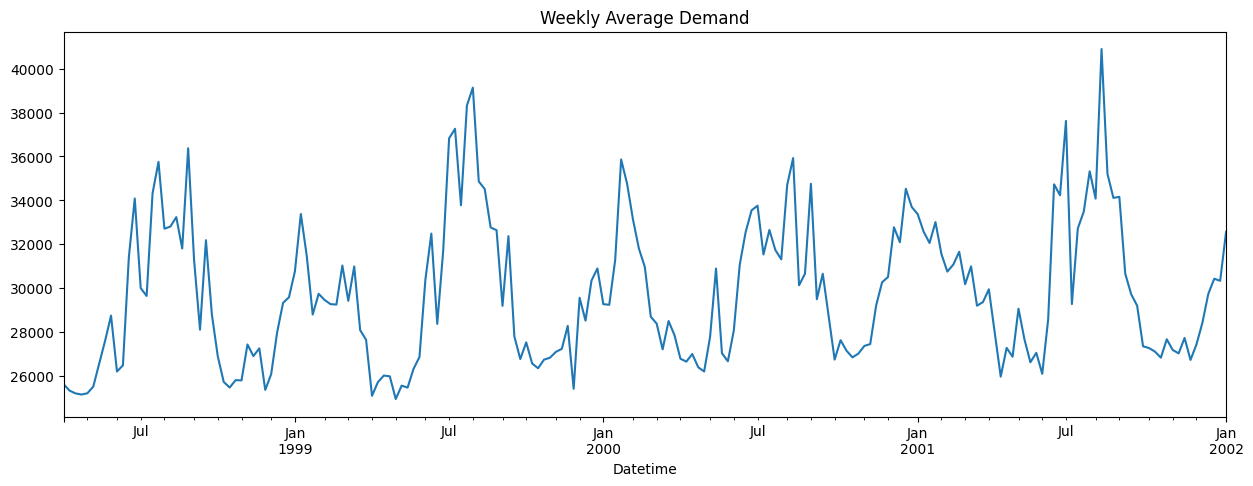

In [ ]:
df_weekly.plot(title='Weekly Average Demand', figsize=(15,5))
plt.savefig('./data/output/pjm_demand_weekly.png', dpi=300)
plt.show()

### Visualize Monthly

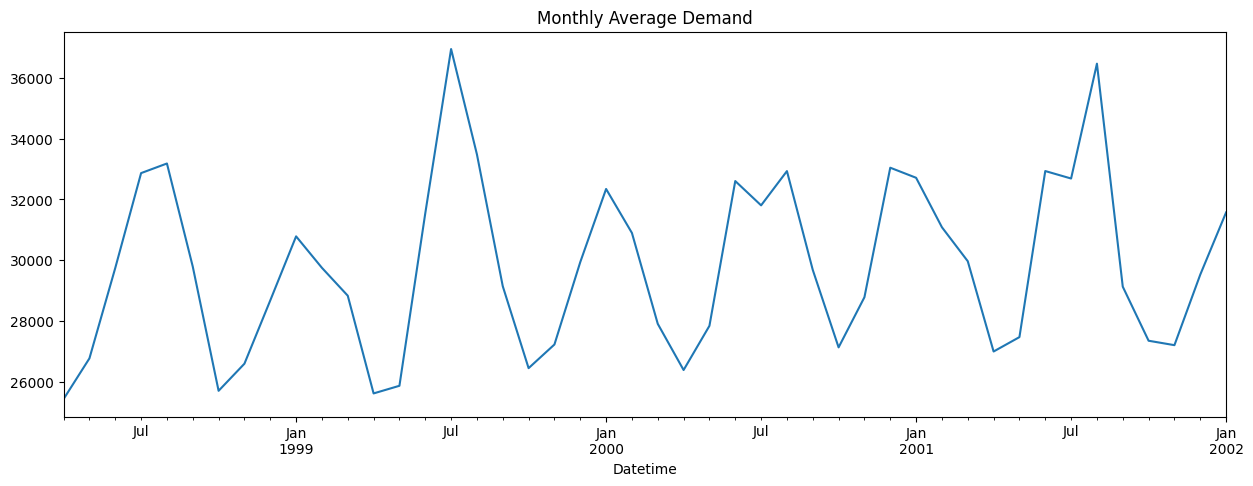

In [ ]:
df_monthly.plot(title='Monthly Average Demand', figsize=(15,5))
plt.savefig('./data/output/pjm_demand_monthly.png', dpi=300)
plt.show()

Conclusion - Hourly data is available, but hourly and daily data are too granular although they show seasonality in consumption pattern, the monthly breakdown here indicates that summer (Jun,Jul,Aug) and winters (Dec,Jan,Feb) are probably the peak consumption in every year

## By Hour, DoW, Month, year

In [ ]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

### Visualize by hour

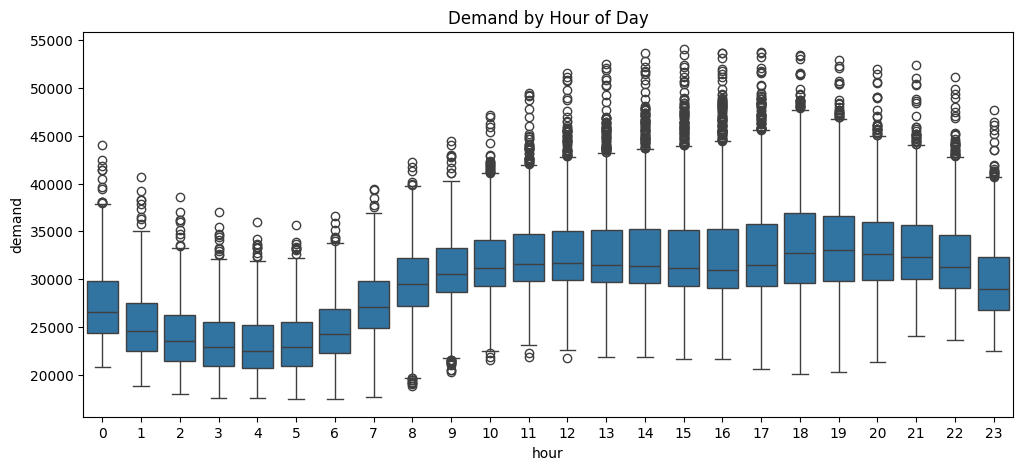

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='hour', y='demand', data=df)
plt.title('Demand by Hour of Day')
plt.savefig('./data/output/pjm_demand_byhour.png', dpi=300)
plt.show()

Conclusion - drop in midnight 2-5am, consumption starts 6am and 5pm to 8pm seems the peak hours (median is quite high), although we start seeing high spikes after 2pm itself

### Visualize by DoW

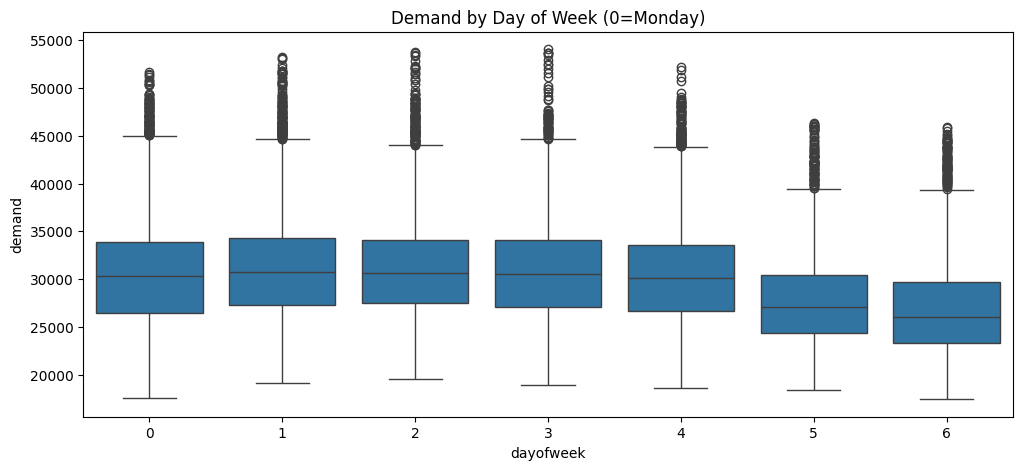

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='dayofweek', y='demand', data=df)
plt.title('Demand by Day of Week (0=Monday)')
plt.savefig('./data/output/pjm_demand_bydow.png', dpi=300)
plt.show()

Conclusion - Weekends is low demands because most commercial places are closed and even in residential areas it could be possible a portion of people spend time in the outdoors

### Visualize by month

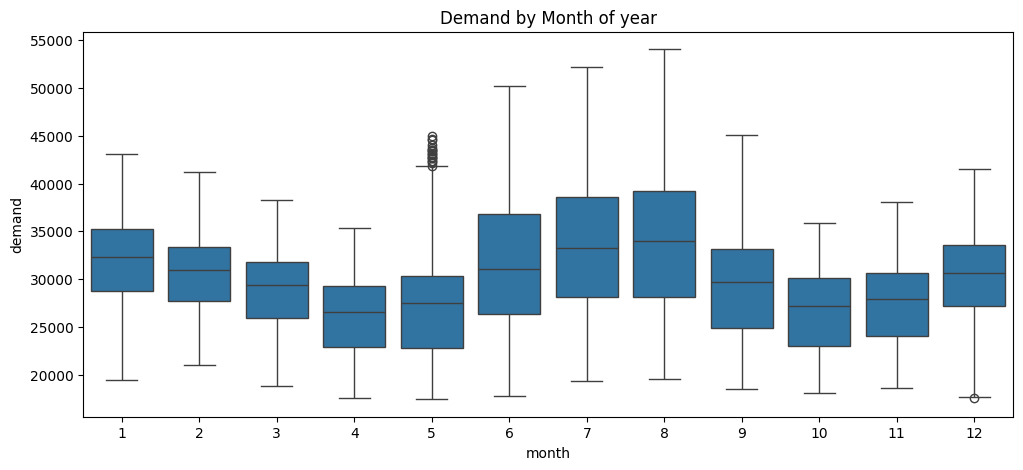

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='month', y='demand', data=df)
plt.title('Demand by Month of year')
plt.savefig('./data/output/pjm_demand_bymonth.png', dpi=300)
plt.show()

Conclusion - the demand starts ramping up in June and the peak is in July and August (Air conditioning in summer probably), we also see an increase in November, December, Jan then slowing down in Feb (Heating in winters probably)

### Visualize by year

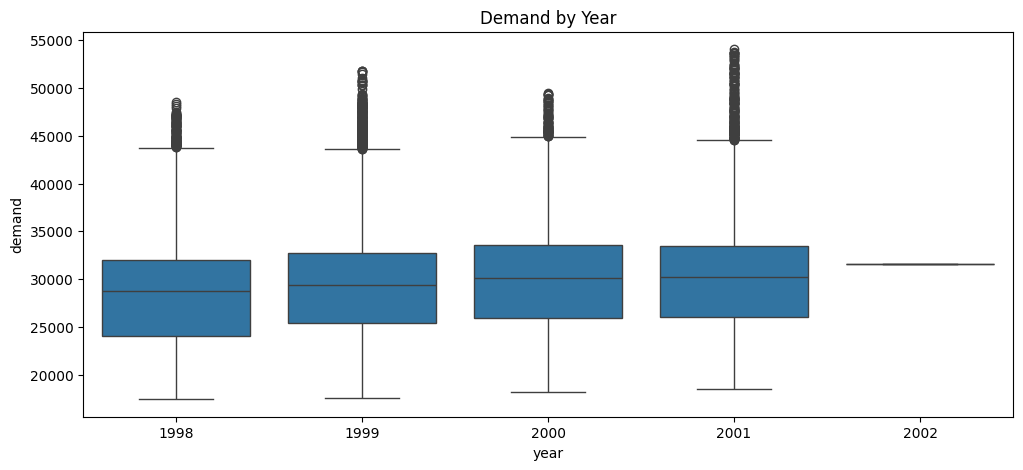

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='year', y='demand', data=df)
plt.title('Demand by Year')
plt.savefig('./data/output/pjm_demand_byyear.png', dpi=300)
plt.show()

## Split

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.cm as cm

def plot_splits(df, splits, strategy_name="Split Strategy"):
    cmap = cm.get_cmap('tab10', 2)  
    
    for i, (train, test) in enumerate(splits):
        plt.figure(figsize=(12, 4))
        
        plt.plot(df.index, df.values, color='lightgray', alpha=0.5)
        
        plt.plot(train.index, train.values, color=cmap(0), lw=1.5)
        
        plt.plot(test.index, test.values, color=cmap(1), lw=2, linestyle='--')
    
        legend_elements = [
            Line2D([0], [0], color='lightgray', lw=1.5, label='Full Series'),
            Line2D([0], [0], color=cmap(0), lw=1.5, label='Train'),
            Line2D([0], [0], color=cmap(1), lw=2, linestyle='--', label='Test')
        ]
        plt.legend(handles=legend_elements)
        
        plt.title(f"{strategy_name} - Fold {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.tight_layout()
        plt.show()


### Holdout

This is a hold out strategy as it sounds we hold on some period of time from the training set to test our model

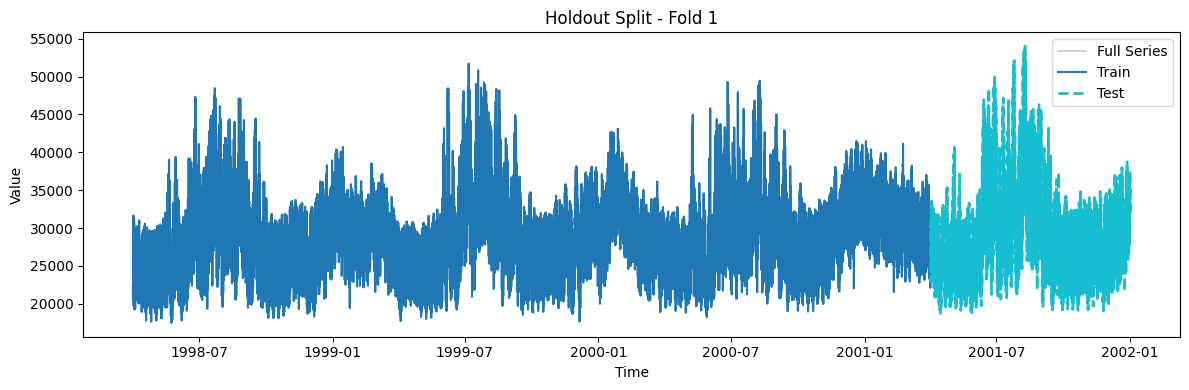

In [ ]:
def get_holdout_split(df, train_ratio=0.8):
    train_size = int(len(df) * train_ratio)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    return train, test

train, test = get_holdout_split(df, train_ratio=0.8)
holdout_splits = [(train, test)]
plot_splits(df['demand'], holdout_splits, strategy_name="Holdout Split")

### Expanding Window

the idea of expanding set is we sequentially train and evaluate the model on more and more data  - this could help us determine how much training data we need or even help us breakdown the training task by snapshotting, evaluating and then adding on more data as we go or in the future

Fold 1: Train [1998-04-01 01:00:00–1998-11-15 16:00:00], Test [1998-11-15 17:00:00–1999-07-02 03:00:00]
Fold 2: Train [1998-04-01 01:00:00–1999-07-02 03:00:00], Test [1999-07-02 04:00:00–2000-02-15 14:00:00]
Fold 3: Train [1998-04-01 01:00:00–2000-02-15 14:00:00], Test [2000-02-15 15:00:00–2000-10-01 01:00:00]
Fold 4: Train [1998-04-01 01:00:00–2000-10-01 01:00:00], Test [2000-10-01 02:00:00–2001-05-17 13:00:00]
Fold 5: Train [1998-04-01 01:00:00–2001-05-17 13:00:00], Test [2001-05-17 14:00:00–2002-01-01 00:00:00]


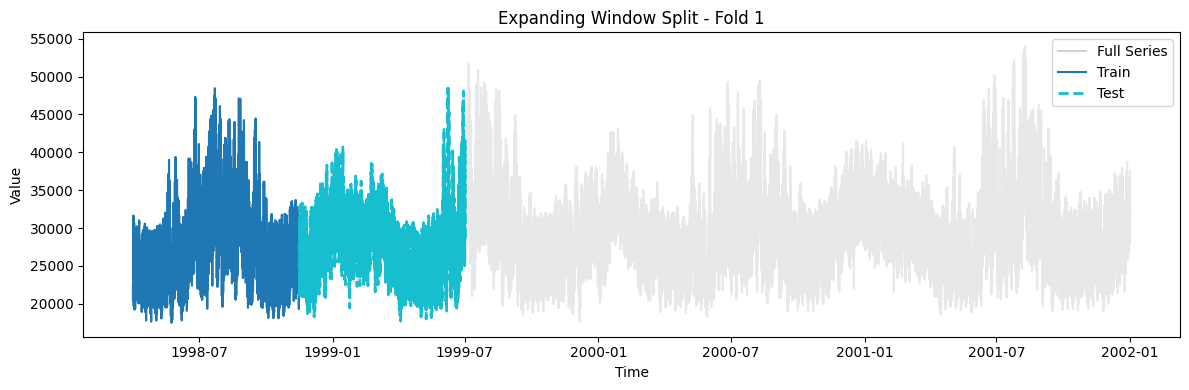

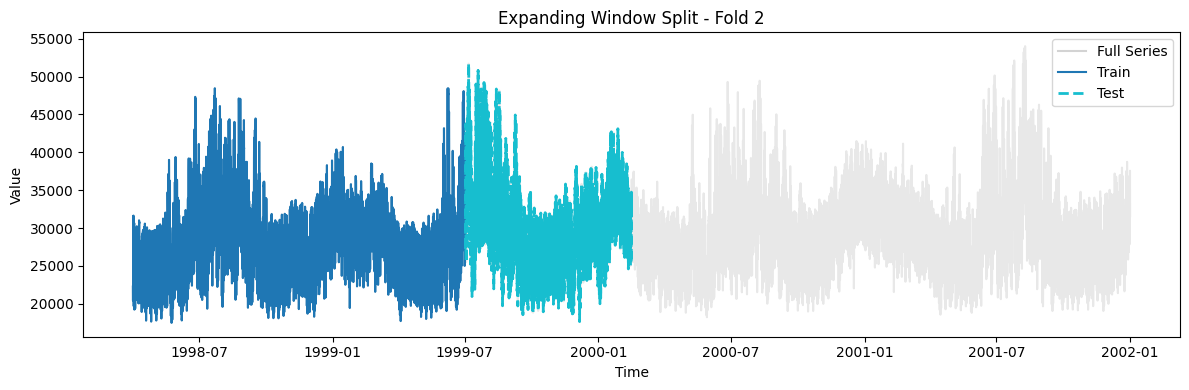

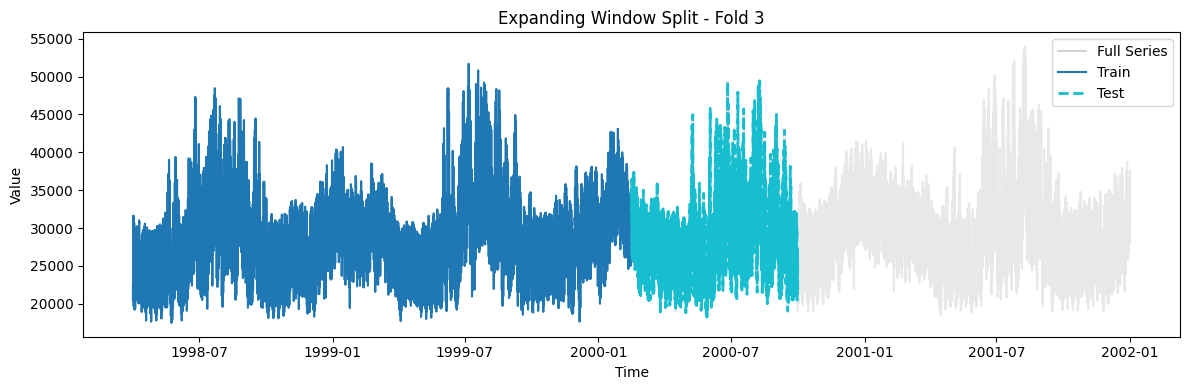

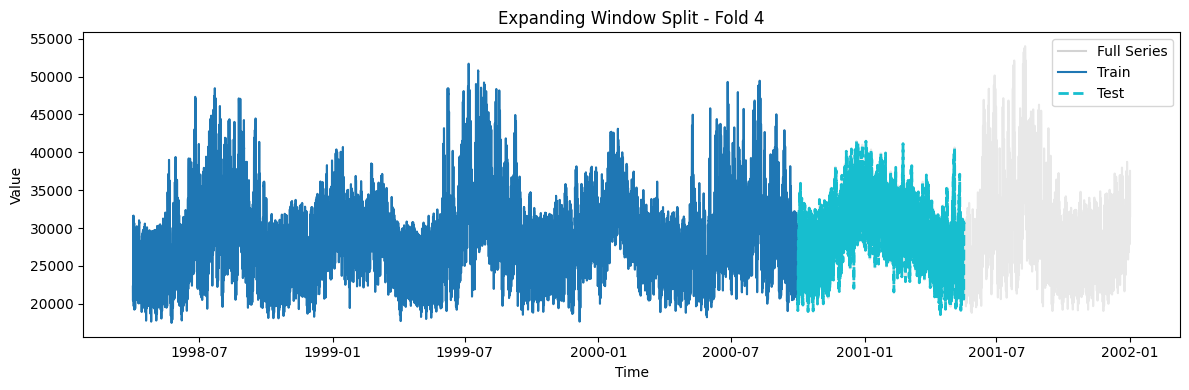

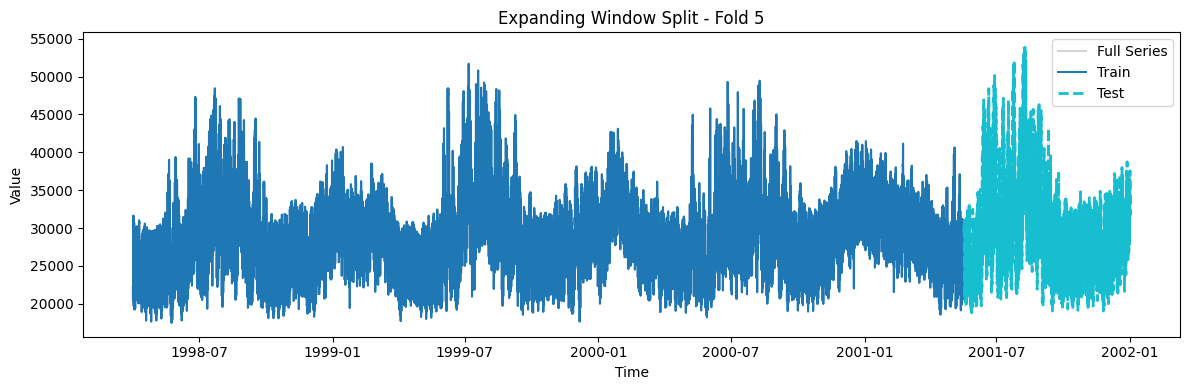

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def get_expanding_window_splits(df, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        splits.append((train, test))
        print(f"Fold {i+1}: Train [{train.index[0]}–{train.index[-1]}], Test [{test.index[0]}–{test.index[-1]}]")
    return splits

expanding_window_splits = get_expanding_window_splits(df)
plot_splits(df['demand'], expanding_window_splits, strategy_name="Expanding Window Split")

Here we show this library called timeseriessplit, which makes it easier to split data in given number - whats a problem is its hard to specify ratio - test set here is way too big for our computation

Now to solve the test size problem we write a custom function

In [ ]:
df.isna().sum()

demand    0
dtype: int64

Fold 1: Train [1998-04-01 01:00:00–1998-07-30 00:00:00] (2880), Test [1998-07-30 01:00:00–1998-10-28 00:00:00] (2160)
Fold 2: Train [1998-04-01 01:00:00–1998-11-27 00:00:00] (5760), Test [1998-11-27 01:00:00–1999-02-25 00:00:00] (2160)
Fold 3: Train [1998-04-01 01:00:00–1999-03-27 00:00:00] (8640), Test [1999-03-27 01:00:00–1999-06-25 00:00:00] (2160)
Fold 4: Train [1998-04-01 01:00:00–1999-07-25 00:00:00] (11520), Test [1999-07-25 01:00:00–1999-10-23 00:00:00] (2160)
Fold 5: Train [1998-04-01 01:00:00–1999-11-22 00:00:00] (14400), Test [1999-11-22 01:00:00–2000-02-20 00:00:00] (2160)
Fold 6: Train [1998-04-01 01:00:00–2000-03-21 00:00:00] (17280), Test [2000-03-21 01:00:00–2000-06-19 00:00:00] (2160)
Fold 7: Train [1998-04-01 01:00:00–2000-07-19 00:00:00] (20160), Test [2000-07-19 01:00:00–2000-10-17 00:00:00] (2160)
Fold 8: Train [1998-04-01 01:00:00–2000-11-16 00:00:00] (23040), Test [2000-11-16 01:00:00–2001-02-14 00:00:00] (2160)
Fold 9: Train [1998-04-01 01:00:00–2001-03-16 00:00

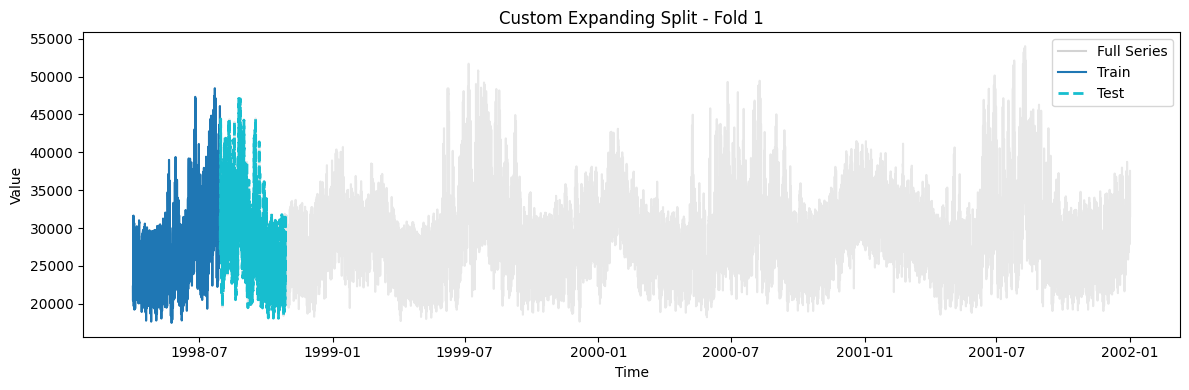

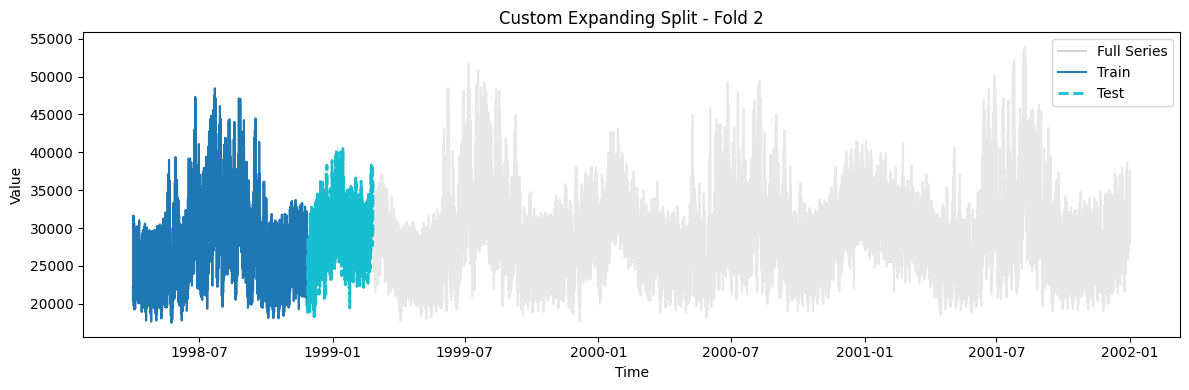

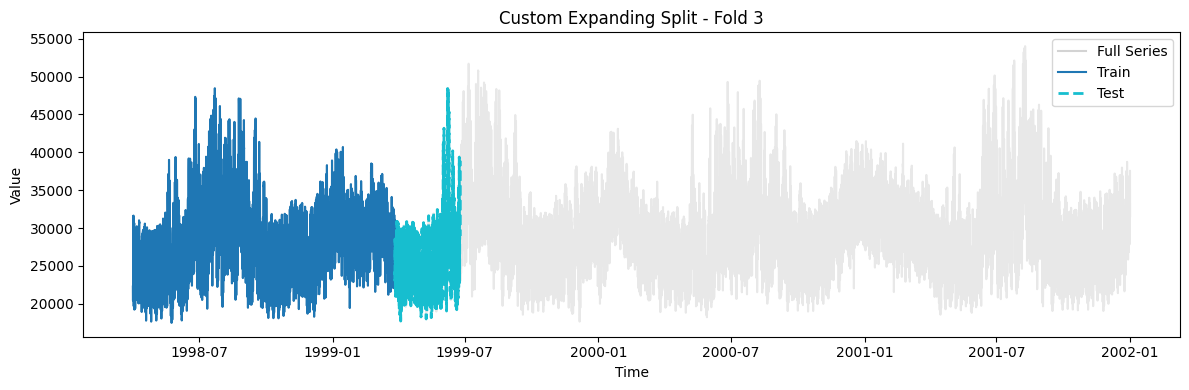

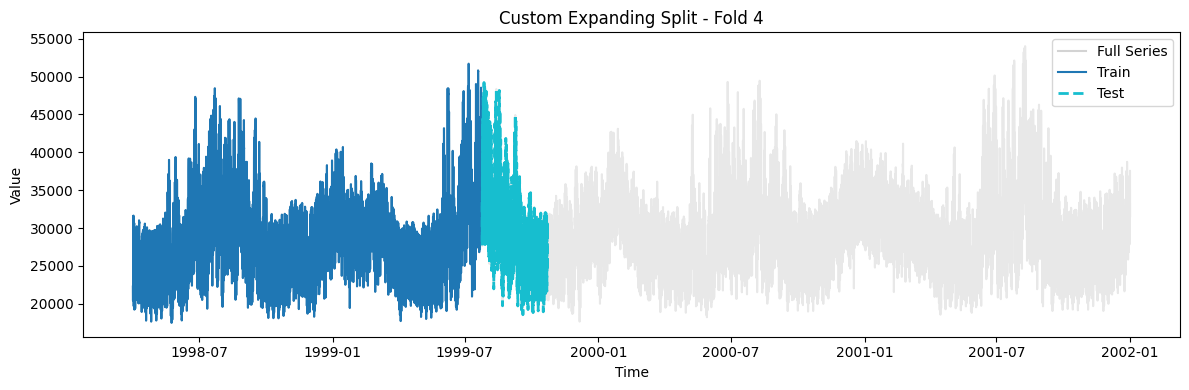

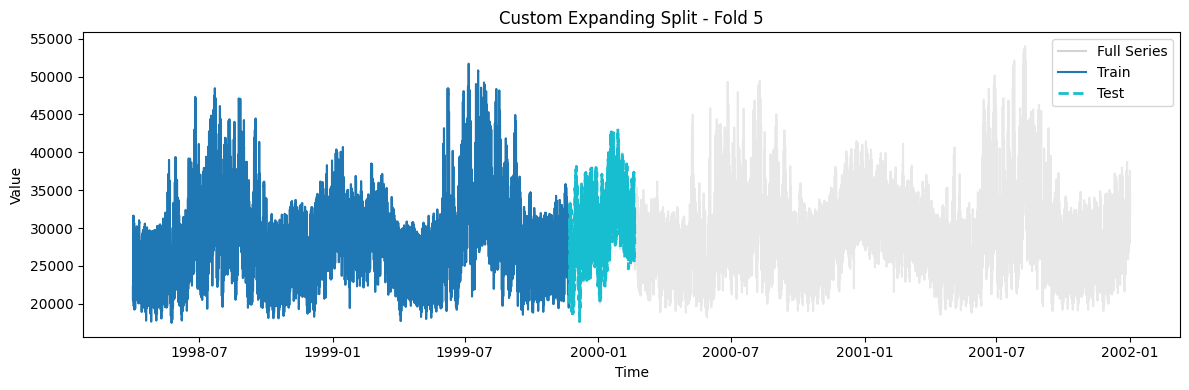

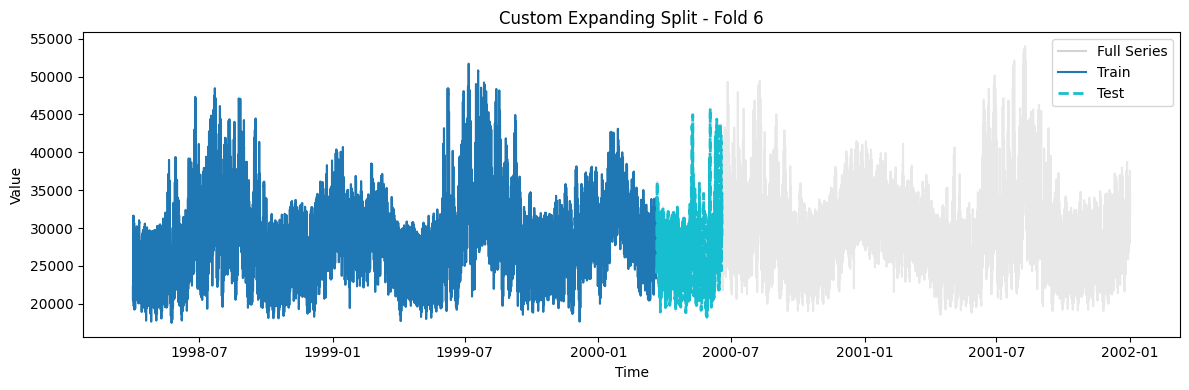

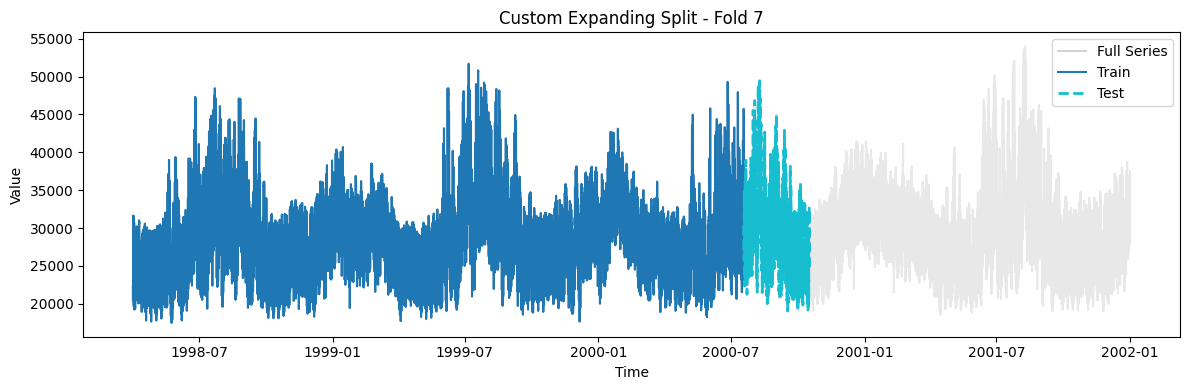

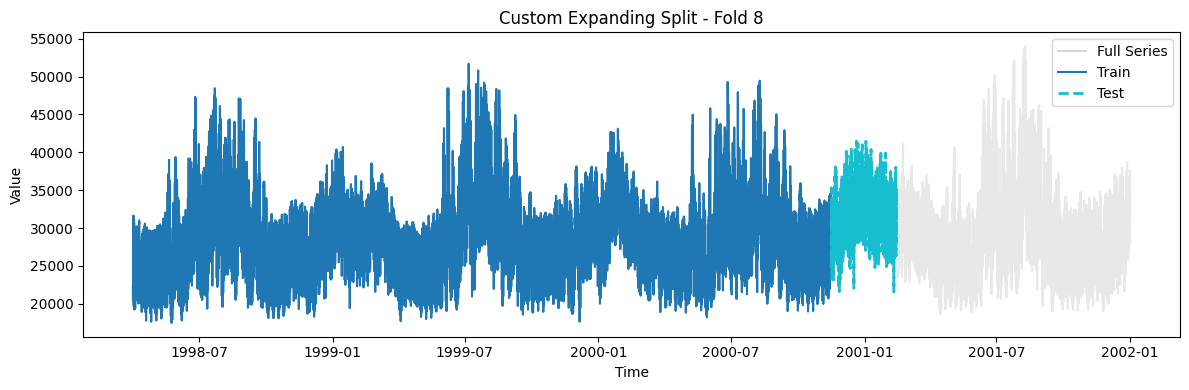

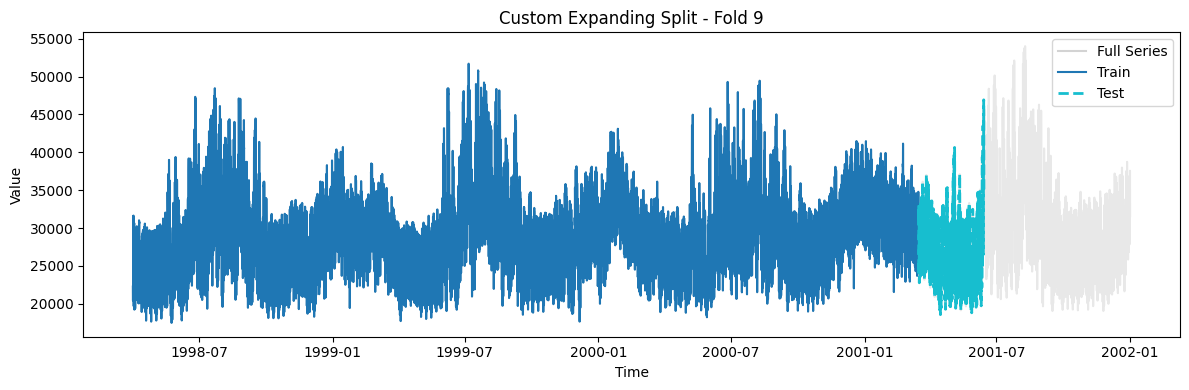

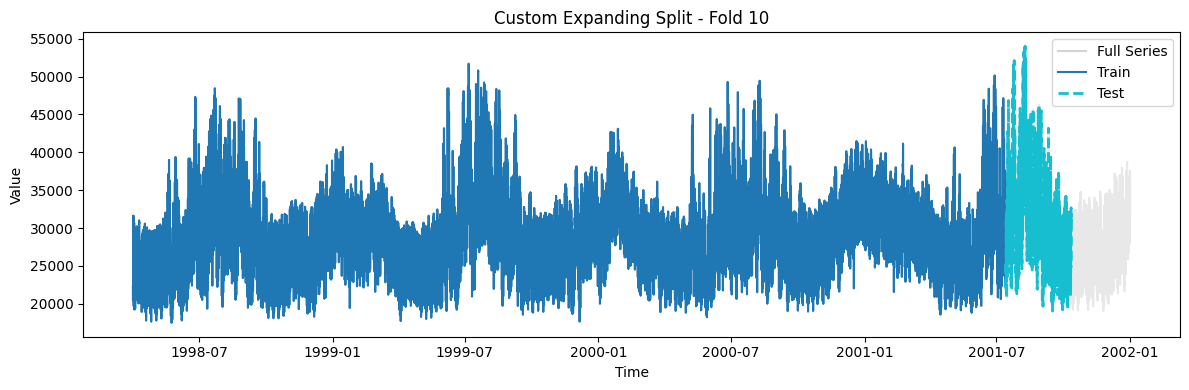

In [ ]:
def get_custom_expanding_splits(df, initial_train_size=24*30,test_size=24*7,max_train_size=None,step_size=24*7):           
    splits = []
    start = 0
    while True:
        end_train = start + initial_train_size
        end_test = end_train + test_size
        if end_test > len(df):
            break

        train = df.iloc[start:end_train]
        test = df.iloc[end_train:end_test]

        splits.append((train, test))
        print(f"Fold {len(splits)}: Train [{train.index[0]}–{train.index[-1]}] ({len(train)}), "
              f"Test [{test.index[0]}–{test.index[-1]}] ({len(test)})")

        if max_train_size is None:
            initial_train_size += step_size
        else:
            initial_train_size = min(initial_train_size + step_size, max_train_size)

    return splits


custom_expanding_window_splits = get_custom_expanding_splits(df, initial_train_size=24*120, test_size=24*90, max_train_size=24*365*4, step_size=24*120)
plot_splits(df['demand'], custom_expanding_window_splits, strategy_name="Custom Expanding Split")

### Rolling Window

This code is for rolling window splits where train size remains the same but the window rolls over different timeframes - this could help develop an ensemble of modelswith appropriate weights  
this is written the same way as previous but with a slight mofication we use timedelta here to make our lives easier

Train [1998-04-01 01:00:00–1999-04-01 01:00:00], Test [1999-04-01 02:00:00–1999-05-01 01:00:00]
Train [1998-07-30 01:00:00–1999-07-30 01:00:00], Test [1999-07-30 02:00:00–1999-08-29 01:00:00]
Train [1998-11-27 01:00:00–1999-11-27 01:00:00], Test [1999-11-27 02:00:00–1999-12-27 01:00:00]
Train [1999-03-27 01:00:00–2000-03-26 01:00:00], Test [2000-03-26 02:00:00–2000-04-25 01:00:00]
Train [1999-07-25 01:00:00–2000-07-24 01:00:00], Test [2000-07-24 02:00:00–2000-08-23 01:00:00]
Train [1999-11-22 01:00:00–2000-11-21 01:00:00], Test [2000-11-21 02:00:00–2000-12-21 01:00:00]
Train [2000-03-21 01:00:00–2001-03-21 01:00:00], Test [2001-03-21 02:00:00–2001-04-20 01:00:00]
Train [2000-07-19 01:00:00–2001-07-19 01:00:00], Test [2001-07-19 02:00:00–2001-08-18 01:00:00]
Train [2000-11-16 01:00:00–2001-11-16 01:00:00], Test [2001-11-16 02:00:00–2001-12-16 01:00:00]


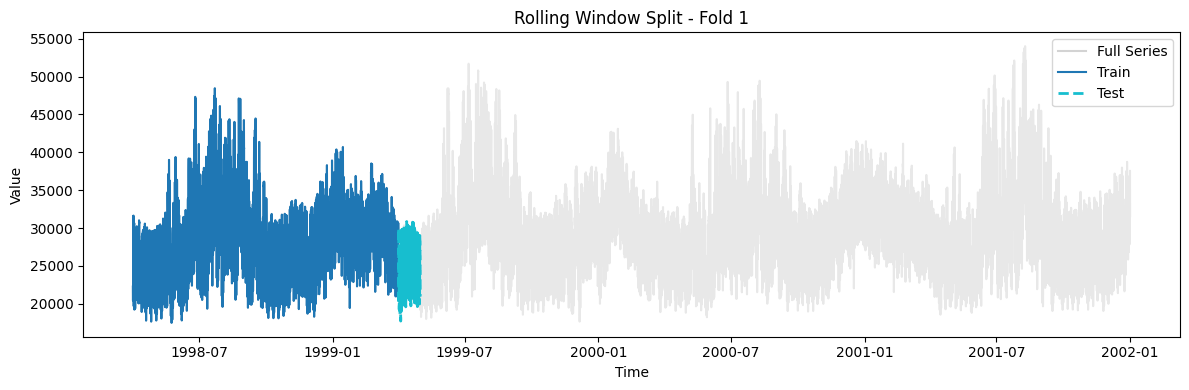

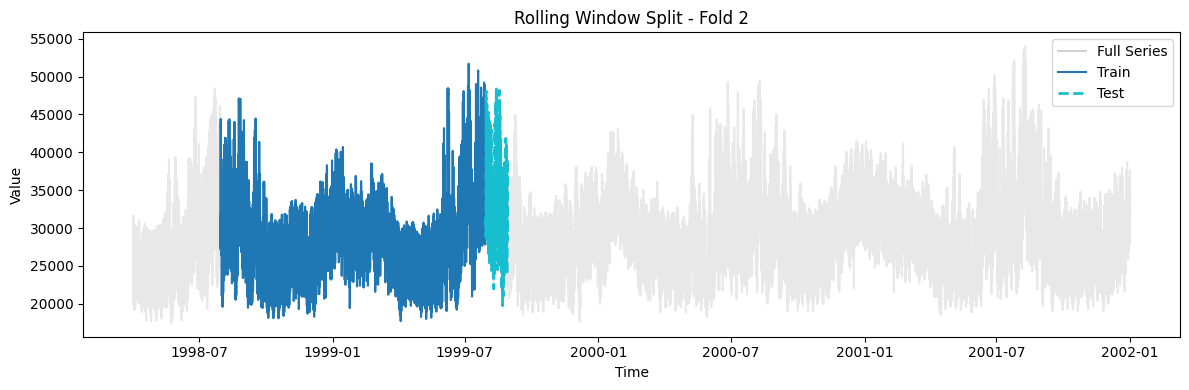

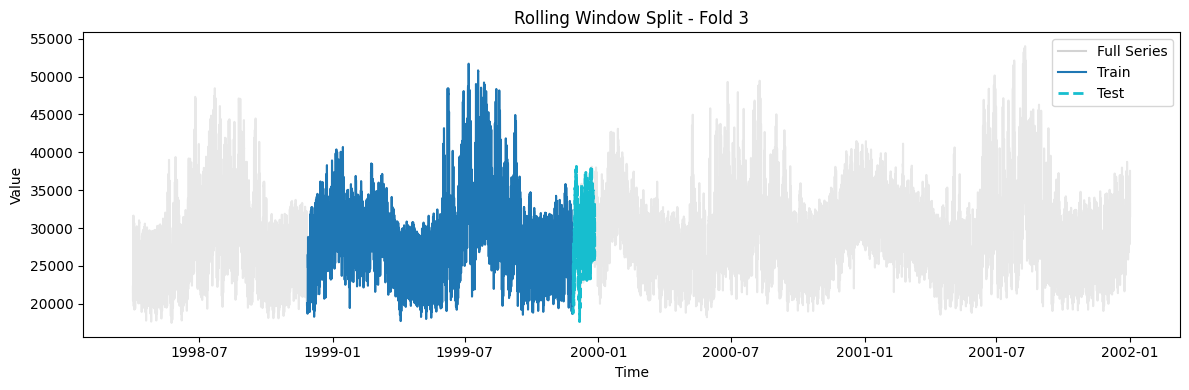

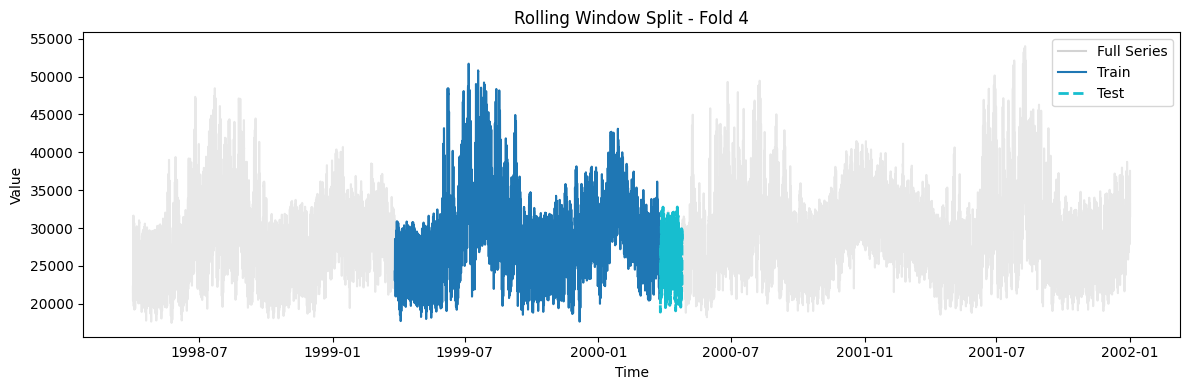

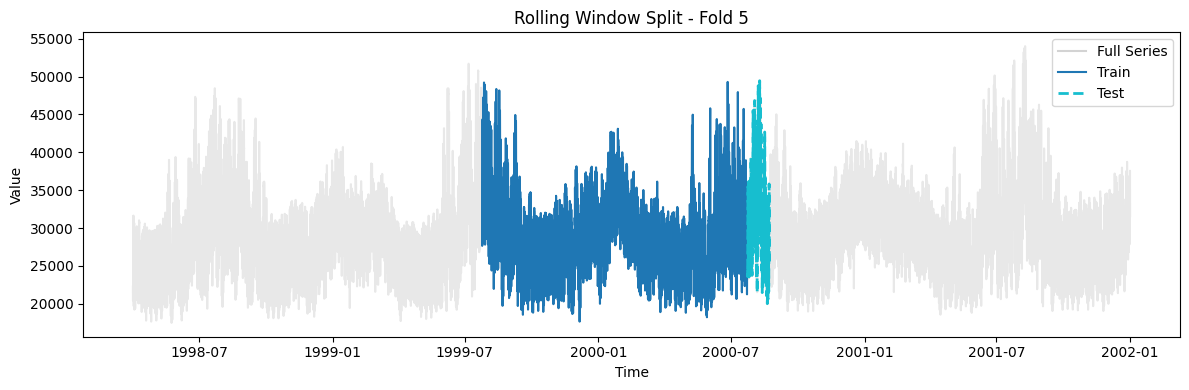

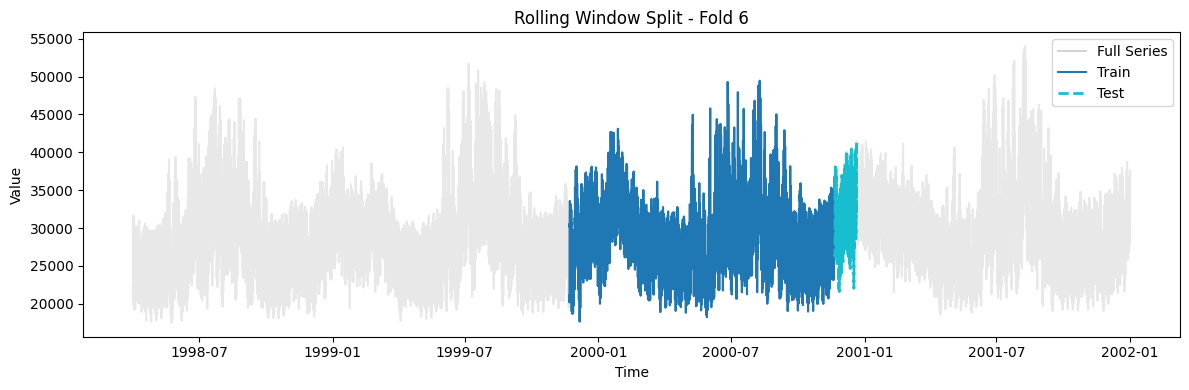

In [ ]:
def get_rolling_window_splits_by_time(df, train_days, test_days, step_days):
    splits = []
    start_date = df.index.min()
    end_date = df.index.max()
    step = pd.Timedelta(days=step_days)
    train_delta = pd.Timedelta(days=train_days)
    test_delta = pd.Timedelta(days=test_days)

    while start_date + train_delta + test_delta <= end_date:
        train_end = start_date + train_delta
        test_end = train_end + test_delta

        train = df.loc[start_date:train_end]
        test = df.loc[train_end + pd.Timedelta(seconds=1):test_end]

        splits.append((train, test))

        print(f"Train [{train.index[0]}–{train.index[-1]}], Test [{test.index[0]}–{test.index[-1]}]")

        start_date += step

    return splits


rolling_window_splits = get_rolling_window_splits_by_time(df, train_days=365, test_days=30, step_days=120)
plot_splits(df['demand'], rolling_window_splits, strategy_name="Rolling Window Split")

### Seasonal

Train [1998-04-01 01:00:00–2001-12-14 21:00:00], Test [2001-12-14 22:00:00–2001-12-30 02:00:00]


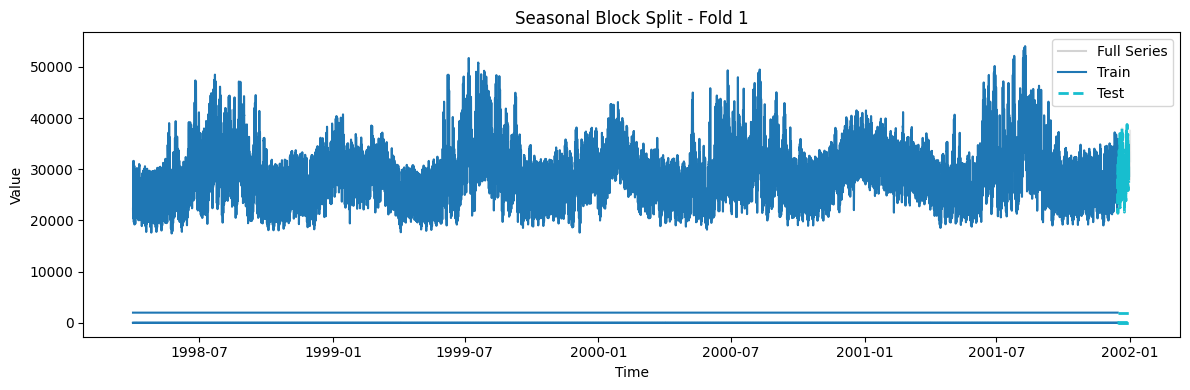

In [ ]:
def get_seasonal_block_split(df, season_length):
    n_full_cycles = len(df) // season_length
    train_size = (n_full_cycles - 1) * season_length
    test_size = season_length
    train = df.iloc[:train_size]
    test = df.iloc[train_size:train_size+test_size]
    print(f"Train [{train.index[0]}–{train.index[-1]}], Test [{test.index[0]}–{test.index[-1]}]")
    return train, test

train, test = get_seasonal_block_split(df, season_length=365)
seasonal_block_split = [(train, test)]
plot_splits(df['demand'], seasonal_block_split, strategy_name="Seasonal Block Split")